In [76]:
#import dependecies
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings('ignore')

import datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

#import dependencies for ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import validation_curve
import math
from math import sqrt


#import dependencies for graphs
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_context("poster")


In [77]:
#connect to a sqlite3 db
conn = sqlite3.connect(r'/Users/rosaicelaroman/Desktop/portfolio_work/earthquake_modeling/Database/db/earthquake_db')
print("Connected to database...")

Connected to database...


In [78]:
model_df = pd.read_sql_query("SELECT * FROM earthquake_raw", conn)
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06T01:42:39.855Z,37.384000,-117.107500,1.10,1.30,ml,8.0,149.46,0.87500,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.1,0.290,4.0,automatic,nn,nn
1,2022-01-06T01:31:33.698Z,38.181000,-117.818000,7.30,1.40,ml,11.0,154.64,0.11900,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.0,0.460,5.0,automatic,nn,nn
2,2022-01-06T01:24:20.083Z,61.340700,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.2,NaN,NaN,automatic,ak,ak
3,2022-01-06T01:15:15.851Z,62.870300,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.8,NaN,NaN,automatic,ak,ak
4,2022-01-06T01:10:44.629Z,64.014500,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.6,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58103,2022-05-10T18:52:32.159Z,-27.668500,-176.934500,25.08,4.60,mb,NaN,76.00,1.80900,0.7400,...,2022-05-31T22:12:12.040Z,Kermadec Islands region,earthquake,10.1,3.7,0.100,34.0,reviewed,us,us
58104,2022-05-10T18:49:23.310Z,-59.013100,-25.575000,55.95,4.90,mb,NaN,65.00,7.65300,0.6000,...,2022-05-31T19:19:19.040Z,South Sandwich Islands region,earthquake,11.6,4.4,0.099,32.0,reviewed,us,us
58105,2022-05-10T16:40:16.050Z,34.731833,-119.073333,11.19,0.83,ml,8.0,168.00,0.02522,0.1500,...,2022-06-07T17:55:46.520Z,"14km SSE of Pine Mountain Club, CA",earthquake,0.5,0.9,0.211,2.0,reviewed,ci,ci
58106,2022-05-10T08:28:40.129Z,2.945500,128.323100,53.98,4.50,mb,NaN,100.00,2.36100,0.8200,...,2022-06-06T07:24:34.040Z,"139 km NNE of Tobelo, Indonesia",earthquake,7.0,7.8,0.111,24.0,reviewed,us,us


In [79]:
#converting time to datetime
model_df['time'] = pd.to_datetime(model_df['time'])
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06 01:42:39.855000+00:00,37.384000,-117.107500,1.10,1.30,ml,8.0,149.46,0.87500,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.1,0.290,4.0,automatic,nn,nn
1,2022-01-06 01:31:33.698000+00:00,38.181000,-117.818000,7.30,1.40,ml,11.0,154.64,0.11900,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.0,0.460,5.0,automatic,nn,nn
2,2022-01-06 01:24:20.083000+00:00,61.340700,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.2,NaN,NaN,automatic,ak,ak
3,2022-01-06 01:15:15.851000+00:00,62.870300,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.8,NaN,NaN,automatic,ak,ak
4,2022-01-06 01:10:44.629000+00:00,64.014500,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.6,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58103,2022-05-10 18:52:32.159000+00:00,-27.668500,-176.934500,25.08,4.60,mb,NaN,76.00,1.80900,0.7400,...,2022-05-31T22:12:12.040Z,Kermadec Islands region,earthquake,10.1,3.7,0.100,34.0,reviewed,us,us
58104,2022-05-10 18:49:23.310000+00:00,-59.013100,-25.575000,55.95,4.90,mb,NaN,65.00,7.65300,0.6000,...,2022-05-31T19:19:19.040Z,South Sandwich Islands region,earthquake,11.6,4.4,0.099,32.0,reviewed,us,us
58105,2022-05-10 16:40:16.050000+00:00,34.731833,-119.073333,11.19,0.83,ml,8.0,168.00,0.02522,0.1500,...,2022-06-07T17:55:46.520Z,"14km SSE of Pine Mountain Club, CA",earthquake,0.5,0.9,0.211,2.0,reviewed,ci,ci
58106,2022-05-10 08:28:40.129000+00:00,2.945500,128.323100,53.98,4.50,mb,NaN,100.00,2.36100,0.8200,...,2022-06-06T07:24:34.040Z,"139 km NNE of Tobelo, Indonesia",earthquake,7.0,7.8,0.111,24.0,reviewed,us,us


In [80]:
for col in model_df.columns:
    print(col)

time
latitude
longitude
depth
mag
magType
nst
gap
dmin
rms
net
id
updated
place
type
horizontalError
depthError
magError
magNst
status
locationSource
magSource


In [81]:
#drop columns not needed
cleaned_df = model_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_df

,latitude,longitude,depth,mag
0,37.384000,-117.107500,1.10,1.30
1,38.181000,-117.818000,7.30,1.40
2,61.340700,-149.885200,30.00,1.50
3,62.870300,-150.762500,111.30,2.10
4,64.014500,-148.765700,1.90,1.50
...,...,...,...,...
58103,-27.668500,-176.934500,25.08,4.60
58104,-59.013100,-25.575000,55.95,4.90
58105,34.731833,-119.073333,11.19,0.83
58106,2.945500,128.323100,53.98,4.50


In [82]:
#find if any column has NaNs
cleaned_df.isnull().sum()

latitude     0
longitude    0
depth        0
mag          6
dtype: int64

In [83]:
#drop NaNs
cleaned_df_dropped = cleaned_df.dropna()

In [84]:
#verify dropped NaNs
cleaned_df_dropped.isnull().sum()

latitude     0
longitude    0
depth        0
mag          0
dtype: int64

In [85]:
#establish features to be used in model. X will use: longitude, longitude, depth and unix time. Y will be magnitude
X = cleaned_df_dropped.drop(['longitude'], axis = 1)

y = cleaned_df_dropped[['longitude']]

In [86]:
#checking number of columns and rows for eacg feature
X.shape, y.shape

((58102, 3), (58102, 1))

In [87]:
#scale and transform the data
# sc_X = StandardScaler()
# sc_y = StandardScaler()
# X = X.fit_transform(X)
# y = y.fit_transform(y)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

Extra Trees Regressor

In [89]:
#create and run model: First with 50 estimators
scores = []
estimators_lst=[]

for i in range(1,50):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    scores.append(score)
    estimators_lst.append(score)

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2 score:", r2, end = ", ")
    print("\tModel score:", score)
max_score = max(scores)
print("Max score:", max_score)
index_max_score = scores.index(max_score) #find the position in the list for max score to get the number of estimators
best_score = max_score
best_model = ExtraTreesRegressor(n_estimators=index_max_score+2, random_state=0)
best_model.fit(X_train, y_train)
best_model_score = best_model.score(X_test, y_test)
print("Best model score: ", best_model_score)


n_estimators=2:
	Mean Squared Error: 1554.3706693359647, 	R2 score: 0.7071974879532448, 	Model score: 0.7071974879532448
n_estimators=3:
	Mean Squared Error: 1397.8011802908075, 	R2 score: 0.7366910576703598, 	Model score: 0.7366910576703598
n_estimators=4:
	Mean Squared Error: 1303.5540725098692, 	R2 score: 0.7544447315242218, 	Model score: 0.7544447315242218
n_estimators=5:
	Mean Squared Error: 1258.333254209805, 	R2 score: 0.7629631431594113, 	Model score: 0.7629631431594113
n_estimators=6:
	Mean Squared Error: 1226.3488795943358, 	R2 score: 0.7689881572814641, 	Model score: 0.7689881572814641
n_estimators=7:
	Mean Squared Error: 1205.632242631455, 	R2 score: 0.7728906262765098, 	Model score: 0.7728906262765098
n_estimators=8:
	Mean Squared Error: 1189.170385341572, 	R2 score: 0.7759916067971292, 	Model score: 0.7759916067971292
n_estimators=9:
	Mean Squared Error: 1167.0812523539341, 	R2 score: 0.7801526179094131, 	Model score: 0.7801526179094131
n_estimators=10:
	Mean Squared Erro

In [90]:
#create and run model: Now with 200 max estimators if no improvement of the score is found
scores = []
counter = 0
import time
start_time = time.perf_counter()
for i in range(1,80):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    current_score = score
    num_estimators = estimators

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2:", r2, end = ", ")
    print("\tModel score:", score)
    if current_score > best_score:
        best_score = current_score
        best_model = model
        num_estimators=i+1
        print('Improvement found!')
        counter = 0
    else:
        counter += 1
    if counter > 60:
        break

end_time = time.perf_counter()
execution_time = end_time - start_time

print(f'Best score found: {best_score:.3f}.')
print(f'Number of estimators: {num_estimators}.')
print(f'Code execution time: {execution_time:.3f} seconds.')

n_estimators=2:
	Mean Squared Error: 1554.3706693359647, 	R2: 0.7071974879532448, 	Model score: 0.7071974879532448
n_estimators=3:
	Mean Squared Error: 1397.8011802908075, 	R2: 0.7366910576703598, 	Model score: 0.7366910576703598
n_estimators=4:
	Mean Squared Error: 1303.5540725098692, 	R2: 0.7544447315242218, 	Model score: 0.7544447315242218
n_estimators=5:
	Mean Squared Error: 1258.333254209805, 	R2: 0.7629631431594113, 	Model score: 0.7629631431594113
n_estimators=6:
	Mean Squared Error: 1226.3488795943358, 	R2: 0.7689881572814641, 	Model score: 0.7689881572814641
n_estimators=7:
	Mean Squared Error: 1205.632242631455, 	R2: 0.7728906262765098, 	Model score: 0.7728906262765098
n_estimators=8:
	Mean Squared Error: 1189.170385341572, 	R2: 0.7759916067971292, 	Model score: 0.7759916067971292
n_estimators=9:
	Mean Squared Error: 1167.0812523539341, 	R2: 0.7801526179094131, 	Model score: 0.7801526179094131
n_estimators=10:
	Mean Squared Error: 1150.5535973810422, 	R2: 0.78326599298125, 	M

Cross-Validation

In [91]:
#define number of splits
k_fold = KFold(n_splits=10)
for train_indices, test_indices in k_fold.split(X):
    print('Train: %s | test: %s' % (train_indices, test_indices))


Train: [ 5811  5812  5813 ... 58099 58100 58101] | test: [   0    1    2 ... 5808 5809 5810]
Train: [    0     1     2 ... 58099 58100 58101] | test: [ 5811  5812  5813 ... 11619 11620 11621]
Train: [    0     1     2 ... 58099 58100 58101] | test: [11622 11623 11624 ... 17429 17430 17431]
Train: [    0     1     2 ... 58099 58100 58101] | test: [17432 17433 17434 ... 23239 23240 23241]
Train: [    0     1     2 ... 58099 58100 58101] | test: [23242 23243 23244 ... 29049 29050 29051]
Train: [    0     1     2 ... 58099 58100 58101] | test: [29052 29053 29054 ... 34859 34860 34861]
Train: [    0     1     2 ... 58099 58100 58101] | test: [34862 34863 34864 ... 40669 40670 40671]
Train: [    0     1     2 ... 58099 58100 58101] | test: [40672 40673 40674 ... 46479 46480 46481]
Train: [    0     1     2 ... 58099 58100 58101] | test: [46482 46483 46484 ... 52289 52290 52291]
Train: [    0     1     2 ... 52289 52290 52291] | test: [52292 52293 52294 ... 58099 58100 58101]


In [92]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_score=cross_val_score(best_model, X, y.values.ravel(), cv=k_fold, n_jobs=-1)
    print(cv_score)

[0.78843493 0.74536989 0.65148079 0.79891384 0.78804601 0.79540228
 0.7957525  0.79912843 0.80257797 0.71349603]


In [93]:
reg_etrees = ExtraTreesRegressor(n_estimators=100, random_state=0)

In [94]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
param_range = np.linspace(1, 100, 5, dtype=int)
train_scores, test_scores = validation_curve(
    reg_etrees,
    X,
    y.values.ravel(),
    param_name="n_estimators",
    param_range=param_range,
    n_jobs=2,
    cv=10
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

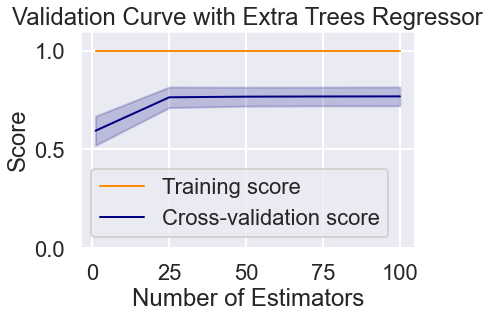

In [95]:

plt.title("Validation Curve with Extra Trees Regressor")
plt.xlabel("Number of Estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

In [96]:
#use the best model to make predictions
testpred = best_model.predict(X_test)
actual_lon = y_test
lon = actual_lon['longitude'].tolist()
testpredict = []
abs_error = []
for item in testpred:
    testpredict.append(item)

maerr=mean_absolute_error(lon, testpredict)
test_mse = mean_squared_error(y_test, testpred)
rmse = sqrt(test_mse)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % maerr)

RMSE: 33.021
MAE: 8.728


In [97]:
print(actual_lon)

        longitude
3616  -122.790667
13495 -122.763167
28367 -117.914700
31835  -66.977667
27553 -151.285700
...           ...
53210 -150.048100
52159 -116.742000
21480 -117.495333
44332 -122.827835
10617   70.949400

[19174 rows x 1 columns]


In [98]:
lon_pred = actual_lon
lon_pred['Predicted'] = testpredict


In [99]:
lon_pred_all = lon_pred.rename(columns={'longitude': 'Actual'})

In [100]:
lon_pred_all

,Actual,Predicted
3616,-122.790667,-122.778075
13495,-122.763167,-122.794424
28367,-117.914700,-108.308732
31835,-66.977667,-66.905063
27553,-151.285700,-150.960869
...,...,...
53210,-150.048100,-149.852011
52159,-116.742000,-116.769930
21480,-117.495333,-117.499076
44332,-122.827835,-122.810035


In [101]:
lon_pred_all = lon_pred.merge(model_df, how='inner', left_index=True, right_index=True)
lon_pred_all = lon_pred_all.rename(columns={'longitude_x': 'Actual', 'longitude_y': 'longitude'})
lon_pred_all

,Actual,Predicted,time,latitude,longitude,depth,mag,magType,nst,gap,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
3616,-122.790667,-122.778075,2021-12-22 11:53:28.400000+00:00,38.819833,-122.790667,1.25,1.14,md,43.0,26.00,...,2021-12-30T12:41:12.200Z,"6km NNW of The Geysers, CA",earthquake,0.13,0.21,0.209000,10.0,reviewed,nc,nc
13495,-122.763167,-122.794424,2022-01-07 02:47:48.980000+00:00,38.824000,-122.763167,0.95,0.08,md,14.0,89.00,...,2022-01-12T00:23:11.195Z,"4km W of Cobb, CA",earthquake,0.27,0.40,0.222000,3.0,reviewed,nc,nc
28367,-117.914700,-108.308732,2022-02-18 05:32:12.402000+00:00,38.163800,-117.914700,10.20,2.70,ml,22.0,103.56,...,2022-03-02T06:48:48.040Z,"30 km SE of Mina, Nevada",earthquake,NaN,0.70,0.230000,9.0,reviewed,nn,nn
31835,-66.977667,-66.905063,2022-03-13 14:58:22.200000+00:00,17.972500,-66.977667,12.28,2.06,md,3.0,180.00,...,2022-03-13T15:29:41.820Z,"6 km WSW of Fuig, Puerto Rico",earthquake,2.33,1.10,0.038064,3.0,reviewed,pr,pr
27553,-151.285700,-150.960869,2022-02-20 07:26:28.782000+00:00,62.942500,-151.285700,110.80,2.00,ml,NaN,NaN,...,2022-02-20T07:39:17.563Z,"56 km NNW of Petersville, Alaska",earthquake,NaN,1.00,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53210,-150.048100,-149.852011,2022-04-25 18:16:17.945000+00:00,61.321200,-150.048100,46.90,1.10,ml,NaN,NaN,...,2022-04-25T18:18:43.674Z,"5 km SW of Point MacKenzie, Alaska",earthquake,NaN,0.50,NaN,NaN,automatic,ak,ak
52159,-116.742000,-116.769930,2022-04-29 05:24:32.810000+00:00,33.695000,-116.742000,14.98,0.19,ml,14.0,83.00,...,2022-04-29T17:11:41.475Z,"5km SSW of Idyllwild, CA",earthquake,0.29,0.37,0.216000,5.0,reviewed,ci,ci
21480,-117.495333,-117.499076,2022-02-11 21:38:34.140000+00:00,33.866333,-117.495333,-0.48,1.19,ml,46.0,46.00,...,2022-02-14T16:14:48.507Z,"3km ESE of Home Gardens, CA",quarry blast,0.30,31.61,0.109000,18.0,reviewed,ci,ci
44332,-122.827835,-122.810035,2022-03-22 19:20:34.790000+00:00,38.813835,-122.827835,1.87,0.85,md,16.0,59.00,...,2022-03-22T19:22:11.331Z,"7km WNW of The Geysers, CA",earthquake,0.24,0.68,NaN,1.0,automatic,nc,nc


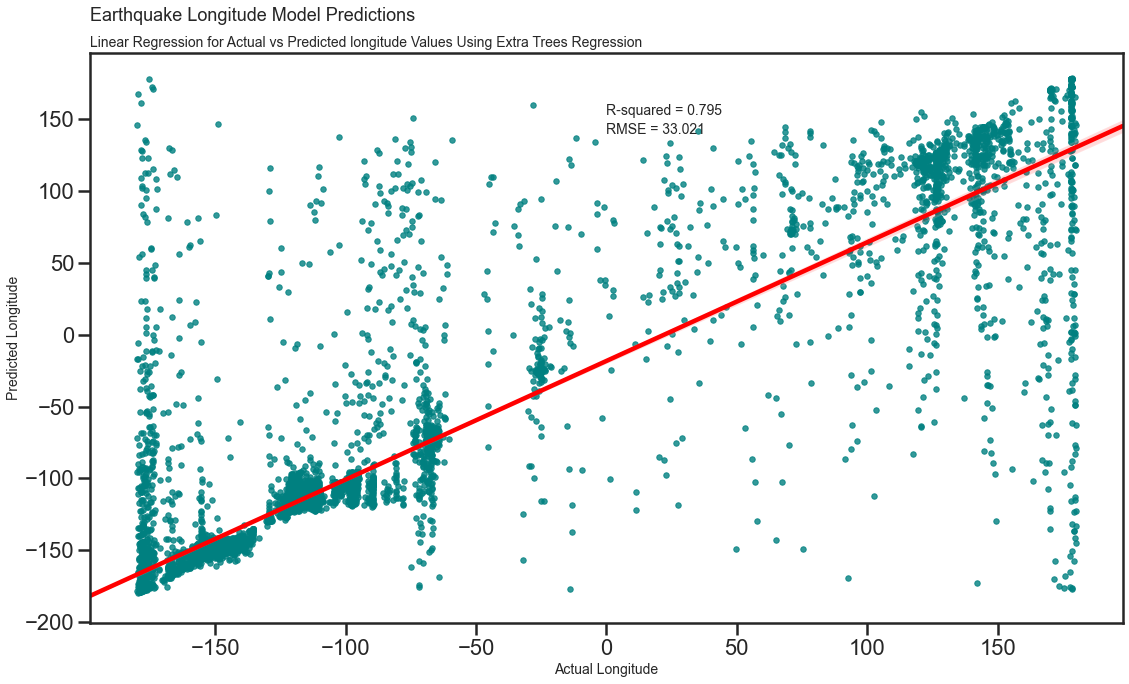

In [102]:
x = np.array(lon_pred_all['longitude'])
y = np.array(testpredict)
# r2_score(y_test, y_pred)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'teal'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Longitude', fontsize=14)
plt.xlabel('Actual Longitude',  fontsize=14)
# Bigger title
plt.suptitle('Earthquake Longitude Model Predictions', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted longitude Values Using Extra Trees Regression', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(lon_pred_all['longitude'], testpredict)), (0, 153),  fontsize=14)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 140), fontsize=14)

fig.savefig('../static/images/extratrees_lonnotime_linear_sns.png', dpi=600)
plt.show()

Test with new data from USGS


In [103]:

page_url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_day.csv"

test_df = pd.read_csv(page_url)
test_df


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-07-09T23:56:25.810Z,19.274666,-155.778839,5.65,2.20,ml,19.0,242.0,NaN,0.25,...,2022-07-10T00:02:03.830Z,"22 km SSE of Honaunau-Napoopoo, Hawaii",earthquake,1.11,2.12,5.690000,3.0,automatic,hv,hv
1,2022-07-09T23:35:39.010Z,33.732500,-116.832000,14.56,0.49,ml,15.0,133.0,0.08894,0.21,...,2022-07-09T23:39:17.504Z,"6km ESE of Valle Vista, CA",earthquake,0.81,1.08,0.166000,12.0,automatic,ci,ci
2,2022-07-09T23:31:02.250Z,32.191167,-116.449000,24.00,1.77,ml,16.0,97.0,0.21870,0.15,...,2022-07-09T23:34:44.270Z,"39km NNE of Ensenada, B.C., MX",earthquake,0.43,1.23,0.261000,20.0,automatic,ci,ci
3,2022-07-09T23:26:33.190Z,38.817833,-122.804833,3.26,0.84,md,12.0,75.0,0.00690,0.01,...,2022-07-09T23:41:19.376Z,"6km NW of The Geysers, CA",earthquake,0.51,1.18,NaN,1.0,automatic,nc,nc
4,2022-07-09T23:18:57.640Z,37.332667,-121.699000,6.37,0.82,md,21.0,45.0,0.04586,0.06,...,2022-07-10T00:02:16.446Z,"12km ESE of Alum Rock, CA",earthquake,0.19,0.41,0.240000,19.0,reviewed,nc,nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,2022-07-09T00:22:13.434Z,18.772900,147.286200,10.00,4.70,mb,38.0,119.0,5.65300,1.02,...,2022-07-09T03:09:32.040Z,Mariana Islands region,earthquake,12.60,1.90,0.106000,27.0,reviewed,us,us
226,2022-07-09T00:14:21.675Z,63.317600,-147.711500,75.00,1.90,ml,NaN,NaN,NaN,0.78,...,2022-07-09T00:17:04.888Z,"62 km E of Cantwell, Alaska",earthquake,NaN,0.70,NaN,NaN,automatic,ak,ak
227,2022-07-09T00:06:27.103Z,61.553400,-146.399500,31.60,1.40,ml,NaN,NaN,NaN,0.52,...,2022-07-09T00:08:11.823Z,"47 km N of Valdez, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
228,2022-07-09T00:03:00.500Z,18.025833,-66.768500,13.98,1.85,md,16.0,104.0,NaN,0.15,...,2022-07-09T00:54:03.660Z,"0 km N of Magas Arriba, Puerto Rico",earthquake,0.40,0.50,0.221710,7.0,reviewed,pr,pr


In [104]:

cleaned_test_df = test_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_test_df



,latitude,longitude,depth,mag
0,19.274666,-155.778839,5.65,2.20
1,33.732500,-116.832000,14.56,0.49
2,32.191167,-116.449000,24.00,1.77
3,38.817833,-122.804833,3.26,0.84
4,37.332667,-121.699000,6.37,0.82
...,...,...,...,...
225,18.772900,147.286200,10.00,4.70
226,63.317600,-147.711500,75.00,1.90
227,61.553400,-146.399500,31.60,1.40
228,18.025833,-66.768500,13.98,1.85


In [105]:

#find if any column has NaNs
cleaned_test_df.isnull().sum()


latitude     0
longitude    0
depth        0
mag          0
dtype: int64

In [106]:

#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X_test_data = cleaned_test_df.drop(['longitude'], axis = 1)

y_test_data = cleaned_test_df[['longitude']]


In [107]:

pred_data_y = best_model.predict(X_test_data)


In [108]:

test_pred_data = cleaned_test_df
test_pred_data['Predicted'] = pred_data_y
test_pred_data


,latitude,longitude,depth,mag,Predicted
0,19.274666,-155.778839,5.65,2.20,-155.314417
1,33.732500,-116.832000,14.56,0.49,-116.825734
2,32.191167,-116.449000,24.00,1.77,-116.510229
3,38.817833,-122.804833,3.26,0.84,-122.803676
4,37.332667,-121.699000,6.37,0.82,-119.479909
...,...,...,...,...,...
225,18.772900,147.286200,10.00,4.70,-74.127402
226,63.317600,-147.711500,75.00,1.90,-149.689338
227,61.553400,-146.399500,31.60,1.40,-148.126480
228,18.025833,-66.768500,13.98,1.85,-66.803220


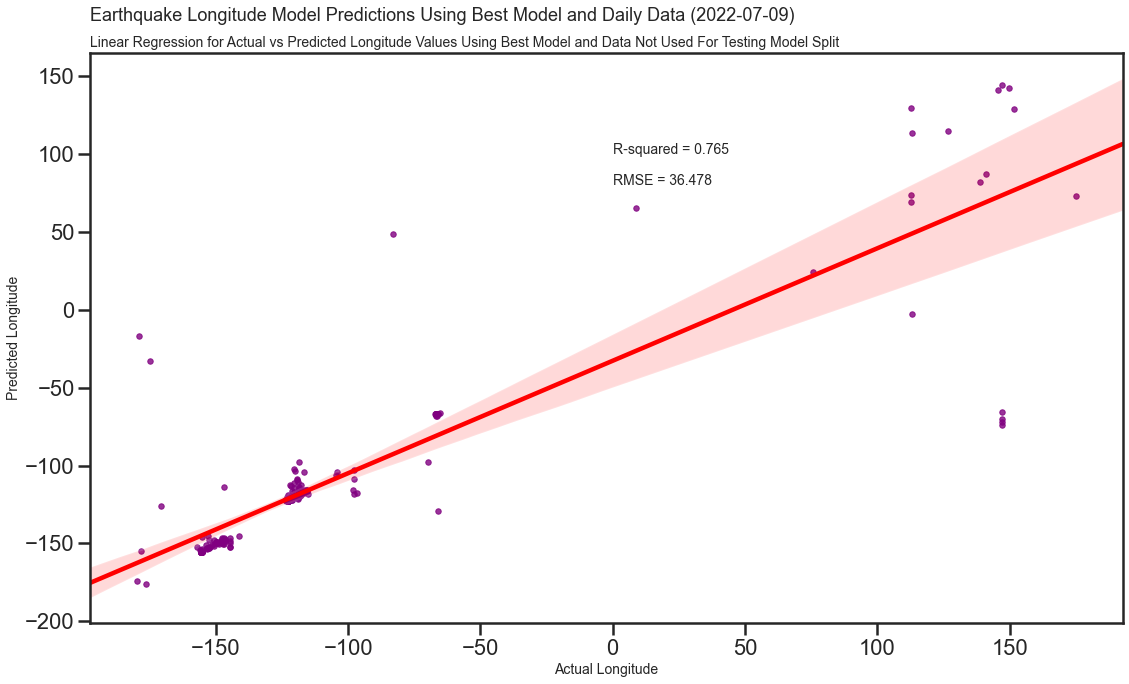

In [109]:
from datetime import date
today = date.today()

x = np.array(test_pred_data['longitude'])
y = np.array(pred_data_y)
test_mse = mean_squared_error(x, y)
rmse = sqrt(test_mse)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'purple'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Longitude', fontsize=14)
plt.xlabel('Actual Longitude',  fontsize=14)
# Bigger title
plt.suptitle(f'Earthquake Longitude Model Predictions Using Best Model and Daily Data ({today})', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Longitude Values Using Best Model and Data Not Used For Testing Model Split', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(x, y)), (0, 100),  fontsize=14)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 80), fontsize=14)

fig.savefig('../static/images/extratrees_lonnotime_linear_sns_daily.png', dpi=600)
plt.show()

In [110]:
#connection to a PostgreSQL local database
# ===========================================

# user_name_var = input('What is the username of your database? ')
host_var = input('What is the host address of your database?')
pw = input("Enter the database password: ")
# db_name = input("Enter the name of the database: ")

string_output = "postgresql://postgres"+':'+pw+'@'+host_var+":5432"+'/earthquake_db'
engine = create_engine(string_output)
connection = engine.connect()
print("Connected to database...")
#create new database with predicted values for both training and test databases
#=============
#PostgreSQL
lon_pred_all.to_sql('earthquake_etrees_lon_notime', engine, if_exists='replace', index = False)
#=============
#SQLite
cur = conn.cursor()
lon_pred_all.to_sql('earthquake_etrees_lon_notime', conn, if_exists='replace', index=False)
# Close connection to SQLite database
conn.close()
connection.close()

Connected to database...
